In [1]:
import os
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import flopy
from flopy.utils.util_array import Util2d
from flopy.modflow import ModflowBas, ModflowLpf
from flopy.utils import ZoneBudget, CellBudgetFile

In [2]:
# Specify the directory you want to clean up
directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS'

# Get a list of all files in the directory
all_files = glob.glob(os.path.join(directory, '*'))

# Specify the file types you want to keep
keep_patterns = ['*.py', '*.ipynb', '*.exe']

# Get a list of files to keep
keep_files = []
for pattern in keep_patterns:
    keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# Specify the directories to skip
skip_directories = ['__pycache__']

# Get a list of files to delete
delete_files = set(all_files) - set(keep_files)

# Delete the files
for file in delete_files:
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue

    if os.path.isfile(file):
        os.remove(file)
    elif os.path.isdir(file):
        shutil.rmtree(file)

In [3]:
# Specify the paths to the model folders
load_folder = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Modflow"
save_folder = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Modflow_SS"

# Load the model
model_name = 'Gondebeek'  # replace 'modelname' with the actual name of your model
m = flopy.modflow.Modflow.load(model_name, model_ws=load_folder)

# Change the model workspace (where the files will be saved)
m.change_model_ws(new_pth=save_folder)

# Change the model name
m.name = 'Gondebeek_SS'



# Change the working directory of the Python environment to save_folder
os.chdir(save_folder)



c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
  warn(


In [4]:
# Get the number of layers, rows, and columns from the model
nlay = m.dis.nlay
nrow = m.dis.nrow
ncol = m.dis.ncol

# Get the top elevation of Layer 1
top_elevation = m.dis.top.array

# Create an array of the same shape as the model grid, filled with the top elevation of Layer 1
strt = np.ones((nlay, nrow, ncol)) * top_elevation

# Get the existing ibound array from the model
ibound = m.bas6.ibound.array

# Remove the existing Basic package from the model
m.remove_package('BAS6')

# Create a new Basic package with the updated strt and the existing ibound
bas = m.bas6 = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

In [5]:
# Set the number of periods
m.dis.nper = 10

# Define the number of time steps
num_time_steps = 30
length_sp=300


# Set the length of each stress period
m.dis.perlen = Util2d(m, (m.dis.nper,), np.float32, [length_sp]*m.dis.nper, name='perlen')

# Set the number of time steps for each stress period
m.dis.nstp = Util2d(m, (m.dis.nper,), np.int32, [num_time_steps]*m.dis.nper, name='nstp')

# Set the stress period type for each stress period
m.dis.steady = Util2d(m, (m.dis.nper,), bool, [True]*m.dis.nper, name='steady')

In [6]:


# Set a constant recharge rate
rch_rate = 703.0074999999999 / 1000 / 365 / 3*length_sp

# Create a dictionary with a single stress period
rch = {0: rch_rate}

# Assign the dictionary to the rech attribute
m.rch.rech = rch

# Set the stream network and properties for each stress period
# Please replace 'segment_data' with the actual attribute that is relevant to your model
segment_data = {i: m.str.segment_data[0] for i in range(m.dis.nper)}
m.str.segment_data = segment_data



In [7]:
# Remove the old NWT package if it exists
if 'NWT' in m.get_package_list():
    m.remove_package('NWT')

# Create a new NWT package
nwt = flopy.modflow.ModflowNwt(m, 
                               headtol=0.001, 
                               fluxtol=700, 
                               maxiterout=4000, 
                               thickfact=1e-7, 
                               linmeth=2, 
                               iprnwt=1, 
                               ibotav=0, 
                               dbdtheta=0.8, 
                               dbdkappa=0.4, 
                               dbdgamma=0.5, 
                               momfact=0.05, 
                               backflag=1, 
                               maxbackiter=400, 
                               backtol=1.05, 
                               backreduce=0.9, 
                               iacl=2, 
                               norder=1, 
                               level=6, 
                               north=4, 
                               iredsys=1, 
                               rrctols=0.0, 
                               idroptol=1, 
                               epsrn=1e-3, 
                               hclosexmd=1e-3, 
                               mxiterxmd=250,
                               options='SPECIFIED')






In [8]:
# Modify the OC package to save output for all stress periods
spd = {(i, t): ['print head', 'print budget', 'save head', 'save budget'] for i in range(m.dis.nper) for t in range(num_time_steps)}
m.oc.stress_period_data = spd
m.oc.save_every = True

# Change the model workspace to the save folder
m.change_model_ws(new_pth=save_folder)

# Write the modified model
m.write_input()
m.check()


Gondebeek_SS MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    RCH package: Mean R/T ratio > checker warning threshold of 0.0002 for 10 stress periods

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    RCH package: Variable NRCHOP set to 3.
    STR package: BC indices valid
    STR package: not a number (Nan) entries
    STR package: BC in inactive cells
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    UPW package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    UPW package: vertical hydr

In [9]:
# Set the path to the MODFLOW-NWT executable
m.exe_name='MODFLOW-NWT.exe'

# Run the model
success, buff = m.run_model()

if not success:
    print("Model did not terminate successfully.")

FloPy is using the following executable to run the model: MODFLOW-NWT.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: Gondebeek_SS.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/02/16 15:40:25

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater-Flow Eqn.
 Solving:

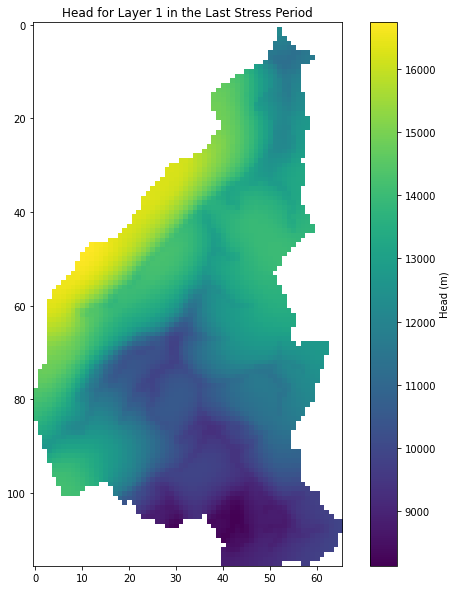

In [11]:
# Load the head data
hds = flopy.utils.HeadFile('Gondebeek.hds')

# Get the head for the last stress period and time step
head = hds.get_data(kstpkper=(29, 9))

# Mask values lower than -900
head = np.ma.masked_where(head < -900, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()

Plot the cell where the maximun head change occurs

In [16]:
# Load the model
modelname = 'Gondebeek_SS'  # replace with your model name if different
sim = flopy.modflow.Modflow.load(modelname, model_ws='.', exe_name='MODFLOW-NWT.exe')

# Get the ibound array from the bas package of the model
ibound = sim.bas6.ibound.array

# Create the zone array from the ibound array
zon = np.where(ibound == 0, 1, ibound)



# Get the cell-by-cell budget file name from the model
cbc_file = "Gondebeek.cbc"

# Check if the file exists
if os.path.exists(cbc_file):
    print("File exists")
else:
    print("File does not exist")


# Create a CellBudgetFile object
cbc = CellBudgetFile(cbc_file)

# Get the kstpkper from the cell budget file
kstpkper = cbc.get_kstpkper()

# Get the last stress period and time step
last_kstpkper = kstpkper[-1]

# Print the kstpkper and last_kstpkper
print("kstpkper:", kstpkper)
print("last_kstpkper:", last_kstpkper)
print(kstpkper)

# Get the last stress period and time step
last_kstpkper = kstpkper[-1]

# Create a ZoneBudget object for the last stress period and time step
zb = ZoneBudget(cbc_file, zon, kstpkper=last_kstpkper)

# Get the budget record array
budget = zb.get_budget()

# Save the budget to a CSV file
f_out = f"{modelname}_output.csv"
zb.to_csv(f_out)

# Print the contents of the CSV file
print(pd.read_csv(f_out).to_string(index=False))

File exists
kstpkper: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (17, 3), (18, 3), (19, 3), (20, 3), (21, 3), (22, 3), 

IndexError: list index out of range